In [2]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'error_gradation_images'

In [5]:
pd.read_csv("../../datasets/california.csv")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price_above_median
0,2.1827,26,4.521429,0.921429,305.0,2.178571,40.05,-122.10,0
1,3.0755,32,4.623068,0.983353,3868.0,4.599287,32.77,-117.06,0
2,1.8235,40,4.701149,1.126437,928.0,3.555556,37.75,-122.16,0
3,1.4625,37,4.247845,1.105603,1673.0,3.605603,33.99,-118.28,0
4,1.9063,13,3.453125,0.984375,286.0,4.468750,33.97,-118.16,0
...,...,...,...,...,...,...,...,...,...
20629,4.3487,29,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,1
20630,5.6790,20,6.401274,1.070064,457.0,2.910828,38.56,-122.05,1
20631,1.9327,10,5.789474,1.078947,898.0,3.938596,38.57,-121.92,1
20632,3.7500,38,5.275229,0.981651,259.0,2.376147,38.72,-121.90,1


In [6]:
data = pd.read_csv("../../datasets/california.csv")
#data.head(10)
#data["OutcomeB"] = data["Outcome"].replace({"F": 1, "M": 0})
n_features = data.shape[1]-1
n = data.shape[0]
target = "price_above_median"
features = data.columns.difference([target]).tolist()
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price_above_median
0,2.1827,26,4.521429,0.921429,305.0,2.178571,40.05,-122.10,0
1,3.0755,32,4.623068,0.983353,3868.0,4.599287,32.77,-117.06,0
2,1.8235,40,4.701149,1.126437,928.0,3.555556,37.75,-122.16,0
3,1.4625,37,4.247845,1.105603,1673.0,3.605603,33.99,-118.28,0
4,1.9063,13,3.453125,0.984375,286.0,4.468750,33.97,-118.16,0


In [69]:
%run ../common_code.ipynb

In [9]:
def entropy(a):
    vc = a.value_counts()
    vc/=vc.sum()
    return -(vc*np.log(vc)).sum()

In [11]:
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [12]:
for col in data_disc.columns:
    print(data_disc[col].value_counts())

AveBedrms
0    20549
1       83
2        2
Name: count, dtype: int64
AveOccup
0    20631
1        2
2        1
Name: count, dtype: int64
AveRooms
0    20530
1      102
2        2
Name: count, dtype: int64
HouseAge
1    8556
0    7135
2    4943
Name: count, dtype: int64
Latitude
0    11761
1     6425
2     2448
Name: count, dtype: int64
Longitude
1    8771
0    8068
2    3795
Name: count, dtype: int64
MedInc
0    11588
1     7788
2     1258
Name: count, dtype: int64
Population
0    18217
1     2415
2        2
Name: count, dtype: int64


In [13]:
model = GradientBoostingClassifier(n_estimators=50)
#model = LogisticRegression()
model.fit(data[features], data[target])

GradientBoostingClassifier(n_estimators=50)

In [14]:
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data[target]+(probs)*(1-data[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,inconf_error
0,2.1827,26,4.521429,0.921429,305.0,2.178571,40.05,-122.10,0.065326
1,3.0755,32,4.623068,0.983353,3868.0,4.599287,32.77,-117.06,0.075973
2,1.8235,40,4.701149,1.126437,928.0,3.555556,37.75,-122.16,0.142387
3,1.4625,37,4.247845,1.105603,1673.0,3.605603,33.99,-118.28,0.135627
4,1.9063,13,3.453125,0.984375,286.0,4.468750,33.97,-118.16,0.104808


In [15]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,AveBedrms,AveOccup,AveRooms,HouseAge,Latitude,Longitude,MedInc,Population,inconf_error
0,0,0,0,1,2,0,0,0,0
1,0,0,0,1,0,2,0,1,0
2,0,0,0,2,1,0,0,0,0
3,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
20629,0,0,0,1,2,0,1,0,2
20630,0,0,0,0,2,0,1,0,0
20631,0,0,0,0,2,0,0,0,2
20632,0,0,0,2,2,0,0,0,2


In [16]:
pipeline_data['cont_features_edges'][4]

array([3.00000000e+00, 2.39520266e+03, 1.78935371e+04, 3.56820000e+04])

In [17]:
pipeline_data['cont_features_edges'][4]

array([3.00000000e+00, 2.39520266e+03, 1.78935371e+04, 3.56820000e+04])

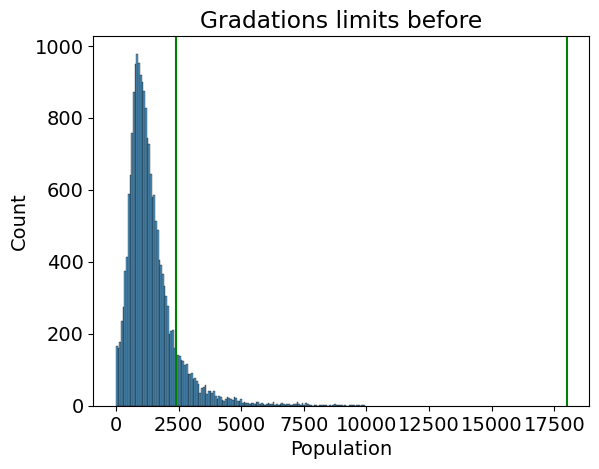

In [18]:
sns.histplot(data[data['Population'] < 10000]['Population'])
plt.title('Gradations limits before')
plt.axvline(x=2400, color='green')
plt.axvline(x=18000, color='green')

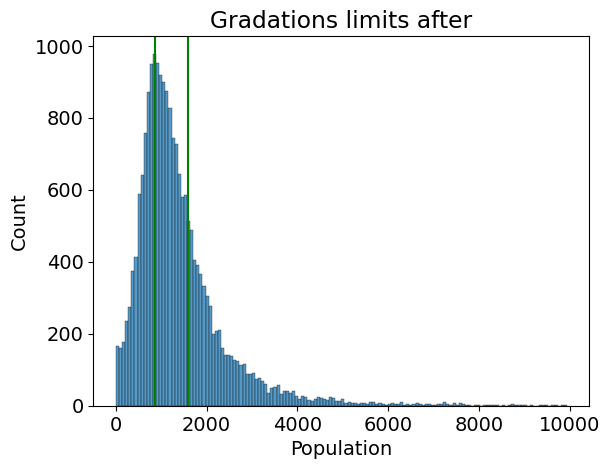

In [19]:
sns.histplot(data[data['Population'] < 10000]['Population'])
plt.title('Gradations limits after')
plt.axvline(x=860, color='green')
plt.axvline(x=1580, color='green')

In [20]:
pipeline_data['cont_features']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'inconf_error']

In [21]:
pipeline_data["cont_features_edges"]

array([array([ 0.4999    ,  3.77284125,  6.91161067, 15.0001    ]),
       array([ 1.        , 22.65697007, 37.9726944 , 52.        ]),
       array([  0.84615385,  15.67636071,  81.6299983 , 141.90909091]),
       array([ 0.33333333,  3.44871907, 17.83710671, 34.06666667]),
       array([3.00000000e+00, 2.39520266e+03, 1.78935371e+04, 3.56820000e+04]),
       array([6.92307692e-01, 2.77022560e+02, 8.97210623e+02, 1.24333333e+03]),
       array([32.54      , 35.68369962, 38.3086873 , 41.95      ]),
       array([-124.35      , -120.17767997, -117.83139817, -114.31      ]),
       array([0.01607368, 0.21732262, 0.4969814 , 0.96696672])],
      dtype=object)

In [23]:
for col in pipeline_data['cont_features']:
    print(data_errors[col].max())

15.0001
52
141.9090909090909
34.06666666666667
35682.0
1243.3333333333333
41.95
-114.31
0.966966719414477


In [24]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
dicval

{'MedInc': [0.4999,
  1.9038,
  2.3523,
  2.7403700000000004,
  3.1406,
  3.5349500000000003,
  3.96738,
  4.4375,
  5.10974,
  6.1587200000000015,
  15.0001],
 'HouseAge': [1.0, 13.0, 17.0, 20.0, 25.0, 29.0, 33.0, 36.0, 40.0, 46.0, 52.0],
 'AveRooms': [0.8461538461538461,
  3.791634193748298,
  4.2671511103087205,
  4.612352592397392,
  4.93406432748538,
  5.229190074906367,
  5.520940695741005,
  5.853784852045721,
  6.268603848385635,
  6.96116085772159,
  141.9090909090909],
 'AveBedrms': [0.3333333333333333,
  0.9663959613696225,
  0.9954170460116255,
  1.0149465105628428,
  1.03243562146217,
  1.048780487804878,
  1.065929926946876,
  1.087059870727432,
  1.115357998402981,
  1.1726750650811717,
  34.06666666666667],
 'Population': [3.0,
  511.0,
  710.0,
  859.0,
  1007.0,
  1166.0,
  1348.800000000001,
  1580.0,
  1907.4000000000015,
  2564.7000000000007,
  35682.0],
 'AveOccup': [0.6923076923076923,
  2.0756544692453844,
  2.3388204334365326,
  2.5115559321441676,
  2.66748533

In [25]:
v = pipeline_data["cont_features_edges"]
for i in [2,3, 5, 4]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [26]:
data__ = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
data__

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,inconf_error
0,0,1,0,0,0,0,2,0,0
1,0,1,1,0,2,2,0,2,0
2,0,2,1,2,1,2,1,0,0
3,0,1,0,2,2,2,0,1,0
4,0,0,0,0,0,2,0,1,0
...,...,...,...,...,...,...,...,...,...
20629,1,1,2,1,1,1,2,0,2
20630,1,0,2,1,0,1,2,0,0
20631,0,0,1,1,1,2,2,0,2
20632,0,2,1,0,0,0,2,0,2


In [75]:
n

20634

In [27]:
for col in data_disc.columns:
    print(data__[col].value_counts())

AveBedrms
1    8254
0    6190
2    6190
Name: count, dtype: int64
AveOccup
1    8254
0    6190
2    6190
Name: count, dtype: int64
AveRooms
1    8254
0    6190
2    6190
Name: count, dtype: int64
HouseAge
1    8556
0    7135
2    4943
Name: count, dtype: int64
Latitude
0    11761
1     6425
2     2448
Name: count, dtype: int64
Longitude
1    8771
0    8068
2    3795
Name: count, dtype: int64
MedInc
0    11588
1     7788
2     1258
Name: count, dtype: int64
Population
1    8255
2    6202
0    6177
Name: count, dtype: int64


In [28]:
current_error = data_errors["inconf_error"].sum()/n
current_error

0.22892687489417532

In [29]:
disc_data["inconf_error"].value_counts()

inconf_error
0    12912
1     5103
2     2619
Name: count, dtype: int64

In [30]:
disc_data = data__

In [31]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

def collect_all_cpds2(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [32]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'MedInc': 3,
 'HouseAge': 3,
 'AveRooms': 3,
 'AveBedrms': 3,
 'Population': 3,
 'AveOccup': 3,
 'Latitude': 3,
 'Longitude': 3,
 'inconf_error': 3}

In [33]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [34]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [35]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,AveRooms,Discrete,disc,[],[]
1,AveBedrms,Discrete,disc,[AveRooms],[disc]
2,MedInc,Discrete,disc,"[AveRooms, AveBedrms]","[disc, disc]"
3,AveOccup,Discrete,disc,"[MedInc, AveRooms, AveBedrms]","[disc, disc, disc]"
4,Population,Discrete,disc,"[AveRooms, AveBedrms, AveOccup]","[disc, disc, disc]"
5,HouseAge,Discrete,disc,"[AveRooms, Population, AveOccup]","[disc, disc, disc]"
6,Longitude,Discrete,disc,"[HouseAge, AveRooms, AveOccup]","[disc, disc, disc]"
7,Latitude,Discrete,disc,"[MedInc, HouseAge, AveRooms, Longitude]","[disc, disc, disc, disc]"
8,inconf_error,Discrete,disc,"[MedInc, AveOccup, Latitude, Longitude]","[disc, disc, disc, disc]"


In [36]:
bn.nodes

[AveRooms,
 AveBedrms,
 MedInc,
 AveOccup,
 Population,
 HouseAge,
 Longitude,
 Latitude,
 inconf_error]

In [37]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [38]:
bn.distributions

{'AveRooms': {'cprob': [0.29999030725986237,
   0.40001938548027527,
   0.29999030725986237],
  'vals': ['0', '1', '2']},
 'AveBedrms': {'cprob': {"['0']": [0.2925686591276252,
    0.42552504038772215,
    0.28190630048465265],
   "['1']": [0.3181487763508602, 0.40731766416283016, 0.27453355948630964],
   "['2']": [0.2831987075928918, 0.3647819063004846, 0.3520193861066236]},
  'vals': ['0', '1', '2']},
 'MedInc': {'cprob': {"['0', '0']": [0.8569850911098841,
    0.13970182219768085,
    0.0033130866924351186],
   "['0', '2']": [0.9255014326647565,
    0.07392550143266476,
    0.0005730659025787965],
   "['0', '1']": [0.9096431283219438,
    0.0888382687927107,
    0.0015186028853454822],
   "['1', '0']": [0.4051789794364052,
    0.5811119573495811,
    0.013709063214013708],
   "['1', '2']": [0.7555163283318623,
    0.23962930273609886,
    0.0048543689320388345],
   "['1', '1']": [0.5895300416418798,
    0.40749553837001784,
    0.00297441998810232],
   "['2', '0']": [0.0325156873930

In [39]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

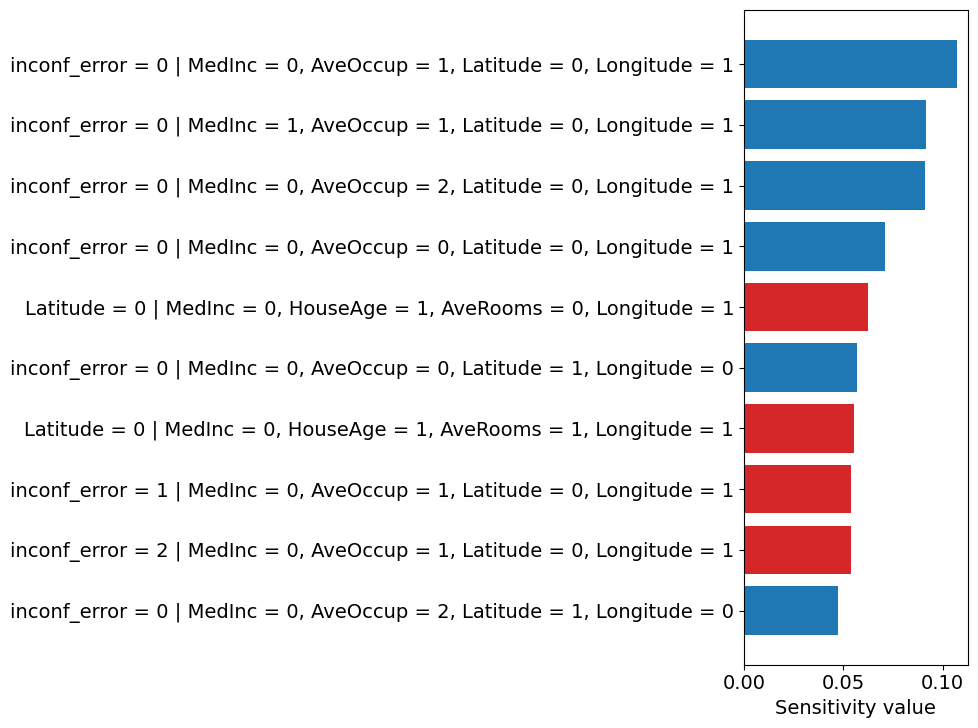

In [40]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 0}, nbars=10)

<Figure size 640x480 with 0 Axes>

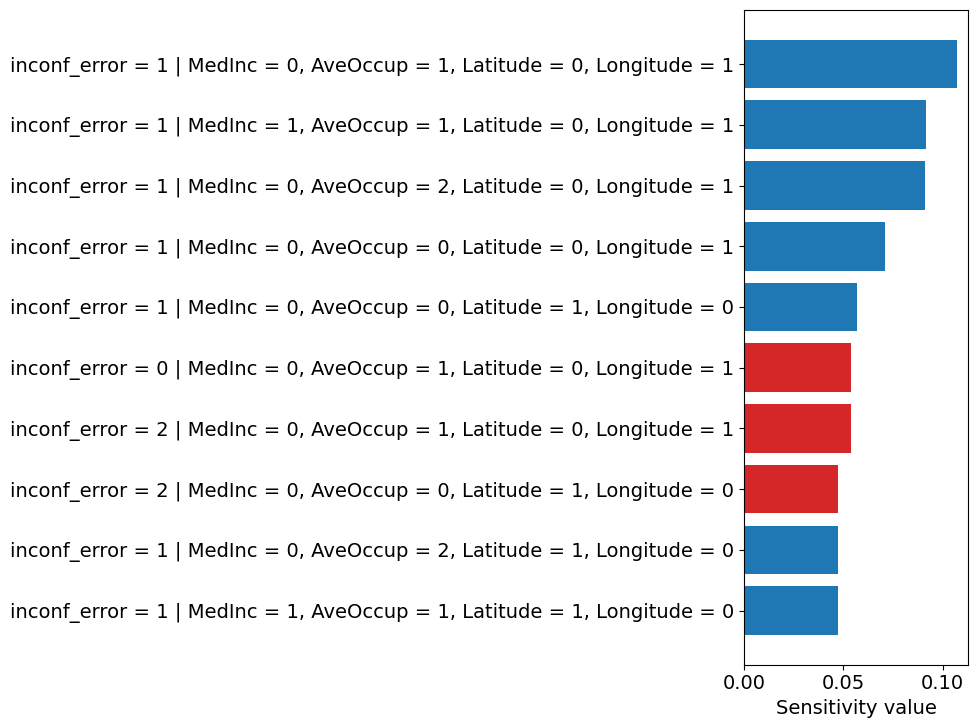

In [41]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 1}, nbars=10)

<Figure size 640x480 with 0 Axes>

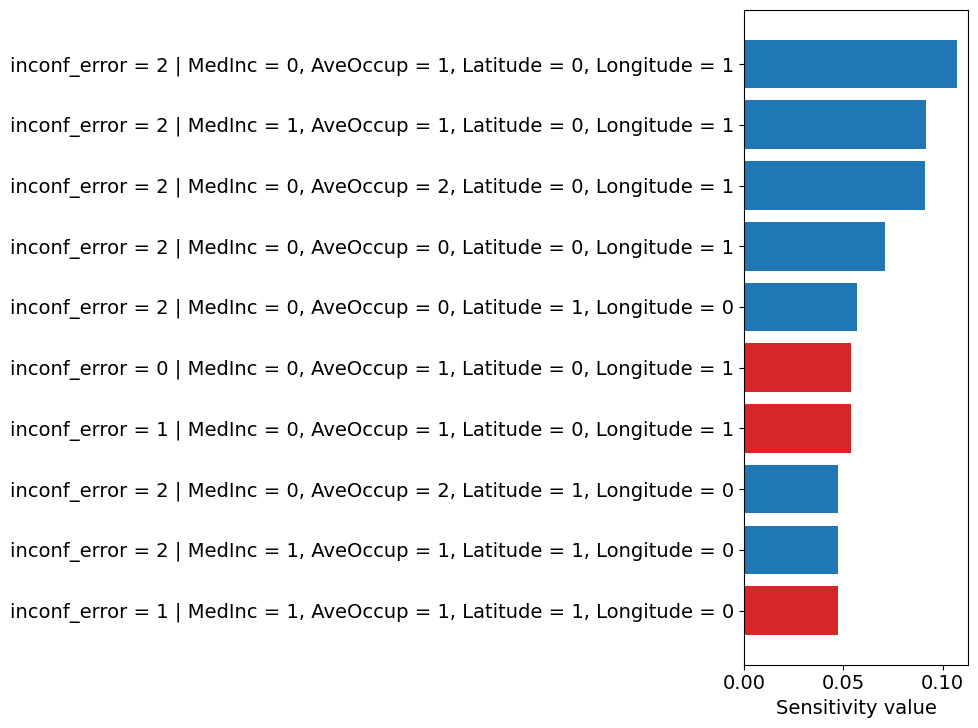

In [42]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

In [43]:
current_error

0.22892687489417532

In [44]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score

In [45]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

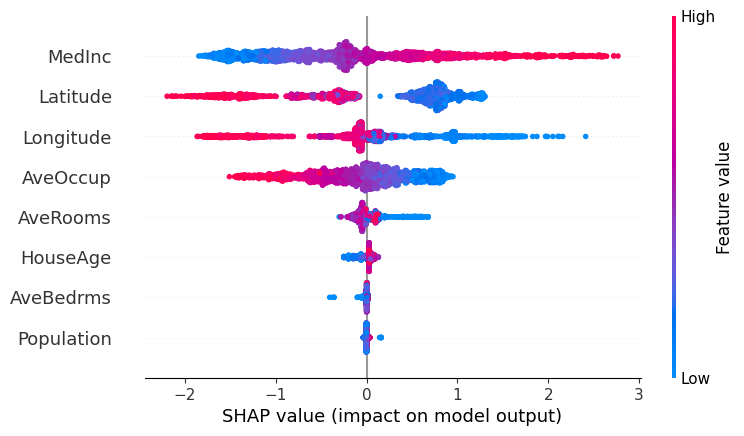

In [46]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['inconf_error']==2][features])
shap.plots.beeswarm(shap_values)

In [47]:
disc_data.shape, data.shape

((20634, 9), (20634, 9))

In [106]:
dfeat = ["MedInc", "AveOccup", "Latitude", "Longitude"]
dcat = [0, 1, 0, 1]

dfeatshap = ["MedInc", "AveOccup", "Latitude", "Longitude"]
dcatshap = [2, 2, 2, 0]

dfeatbn = ["MedInc", "MedInc", "Latitude", "Longitude", "Longitude"]
dcatbn = [1, 2, 0, 0, 2]


d_dict={
    'yodo': [["MedInc", "AveOccup", "Latitude", "Longitude"], [0, 1, 0, 1]],
    'bn': [["MedInc", "AveOccup", "Latitude", "Longitude"], [2, 2, 2, 0]],
    'shap': [["MedInc", "MedInc", "Latitude", "Longitude", "Longitude"], [1, 2, 0, 0, 2]]
}

bn = n//4

In [107]:
n, bn

(20634, 5158)

In [116]:
%run ../common_code.ipynb

In [117]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    roc_auc_score], trials=50,alpha=0.9, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)



100%|██████████| 50/50 [09:36<00:00, 11.54s/it]


In [118]:
stats_res['avg_n_dropped']

{'yodo': 330.72, 'bn': 330.5, 'shap': 330.84, 'init': -1, 'random': -1}

In [119]:
def plot_scores(metrics, labels, graph_label, k):
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        
    plt.legend()
    plt.xlabel(graph_label)

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

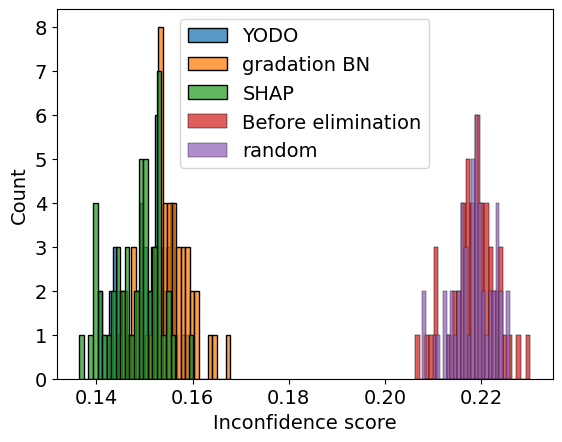

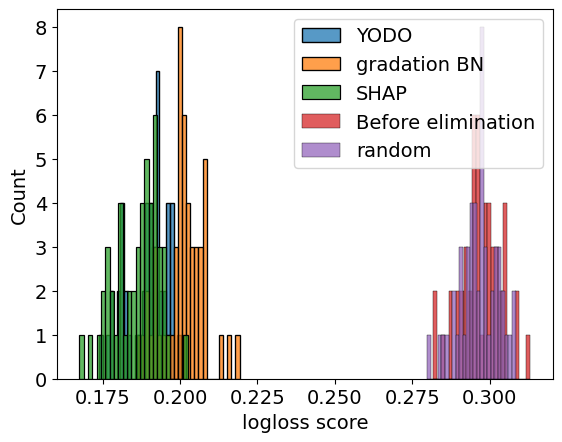

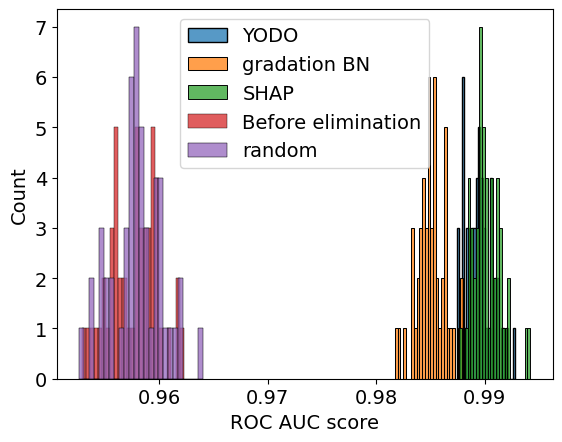

In [120]:
for k, label in enumerate(['Inconfidence score', 'logloss score', 'ROC AUC score']):
    plt.figure()
    plot_scores(stats_res['metrics'], ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ], label, k)

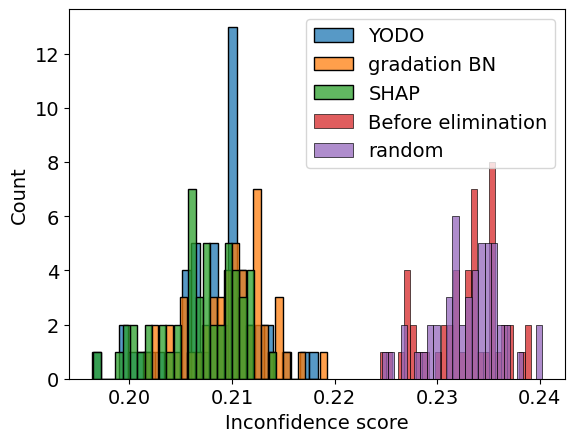

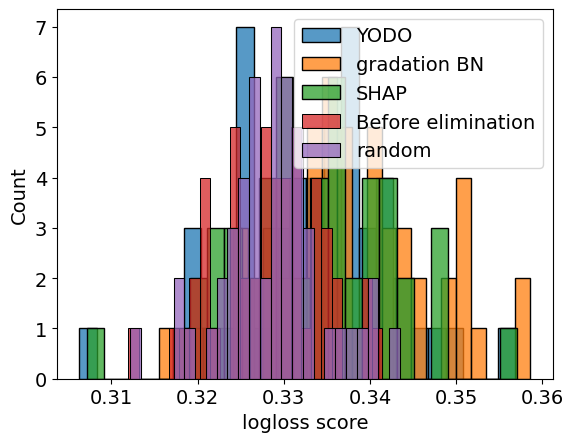

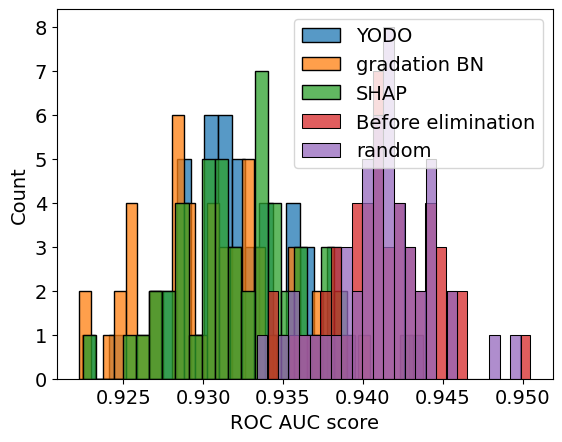

In [ ]:

# test
for k, label in enumerate(['Inconfidence score', 'logloss score', 'ROC AUC score']):
    plt.figure()
    plot_scores(stats_res['metrics_test'], ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ], label, k)

In [122]:
# Среднее улучшение скоров в процентах
improve = [-sum((a-b)/b for a, b in zip(y[0], stats_res['metrics']['init'][0]))/50*100 for y in stats_res['metrics'].values()]
improve

[31.204289061651608,
 29.23876714336507,
 32.25153753916821,
 -0.0,
 0.1000902186977]

In [123]:
improve = [-sum((a-b)/b for a, b in zip(y[0], stats_res['metrics_test']['init'][0]))/50*100 for y in stats_res['metrics'].values()]
improve

[35.34716171167246,
 33.49650543349931,
 36.326104076952774,
 6.028739172715961,
 6.126984516552606]

In [124]:
improve = [-sum((a-b)/b for a, b in zip(y[2], stats_res['metrics_test']['init'][2]))/50*100 for y in stats_res['metrics'].values()]
improve

[-5.110042649231047,
 -4.644622535717807,
 -5.187360821565657,
 -1.7357111741224678,
 -1.7729631923471851]

In [125]:
percentage_changes = {a: list() for a in stats_res['metrics'].keys()}

mean_differences = {a: list() for a in stats_res['metrics'].keys()}

percentage_changes_test = {a: list() for a in stats_res['metrics'].keys()}

mean_differences_test = {a: list() for a in stats_res['metrics'].keys()}

mean_differences2 = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    metrics_info_all = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    roc_auc_score], trials=50,alpha=a, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)
    
    metrics_info, metrics_info_test = metrics_info_all['metrics'], metrics_info_all['metrics_test']
    if a == 0:
        print(_)
        
    for name in stats_res['metrics'].keys():
        x, y = np.array(metrics_info['init'][0]), np.array(metrics_info[name][0])
        mean_differences[name].append((x-y).mean())

        percentage_changes[name].append((-(y-x)/x).mean()*100)

        x, y = np.array(metrics_info_test['init'][0]), np.array(metrics_info_test[name][0])
        mean_differences_test[name].append((x-y).mean())

        percentage_changes_test[name].append((-(y-x)/x).mean()*100)

    

for name in stats_res['metrics'].keys():
    mean_differences[name].append(0)
    percentage_changes[name].append(0)
    mean_differences_test[name].append(0)
    percentage_changes_test[name].append(0)


100%|██████████| 50/50 [06:22<00:00,  7.66s/it]


[-5.110042649231047, -4.644622535717807, -5.187360821565657, -1.7357111741224678, -1.7729631923471851]


100%|██████████| 50/50 [09:00<00:00, 10.81s/it]


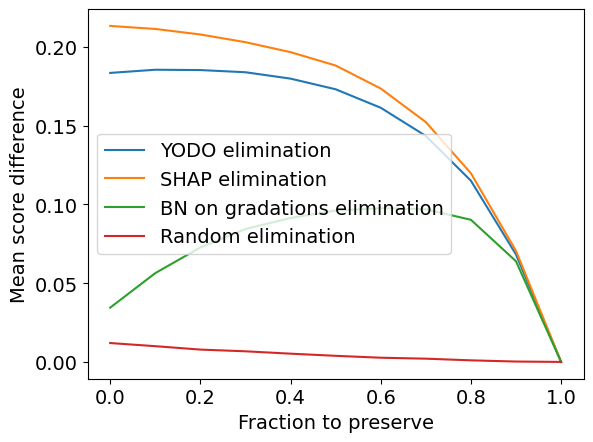

In [127]:
plt.plot(alphas, mean_differences['yodo'], label='YODO elimination')
plt.plot(alphas, mean_differences['shap'], label='SHAP elimination')
plt.plot(alphas, mean_differences['bn'], label='BN on gradations elimination')
plt.plot(alphas, mean_differences['random'], label='Random elimination')
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")
plt.legend()

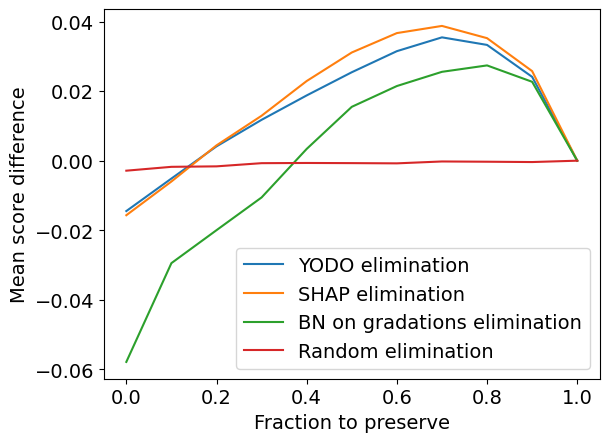

In [128]:
plt.plot(alphas, mean_differences_test['yodo'], label='YODO elimination')
plt.plot(alphas, mean_differences_test['shap'], label='SHAP elimination')
plt.plot(alphas, mean_differences_test['bn'], label='BN on gradations elimination')
plt.plot(alphas, mean_differences_test['random'], label='Random elimination')
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")
plt.legend()

In [49]:
from scipy.stats import ttest_rel

In [39]:
ttest_rel(mses_before, mses_after)

NameError: name 'mses_before' is not defined

In [254]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=5.389314443207421, pvalue=1.0925112258579377e-07, df=499)

In [48]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,MedInc_0,MedInc_1,MedInc_2,HouseAge_0,HouseAge_1,HouseAge_2,AveRooms_0,AveRooms_1,AveRooms_2,AveBedrms_0,...,AveOccup_2,Latitude_0,Latitude_1,Latitude_2,Longitude_0,Longitude_1,Longitude_2,inconf_error_0,inconf_error_1,inconf_error_2
0,1,0,0,0,1,0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
1,1,0,0,0,1,0,0,1,0,1,...,1,1,0,0,0,0,1,1,0,0
2,1,0,0,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,1,0,0
3,1,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20629,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
20630,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
20631,1,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
20632,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,1


In [49]:
from itertools import product

In [50]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-16 17:54:57,798 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,799 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,800 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8


2025-03-16 17:54:57,801 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,803 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,803 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,805 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,807 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,808 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,809 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,810 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,811 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-16 17:54:57,812 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [51]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,Latitude_1,Discrete,disc,[],[]
1,Latitude_2,Discrete,disc,[],[]
2,AveOccup_0,Discrete,disc,"[Latitude_1, Latitude_2]","[disc, disc]"
3,MedInc_0,Discrete,disc,"[AveOccup_0, Latitude_2]","[disc, disc]"
4,AveRooms_0,Discrete,disc,"[MedInc_0, AveOccup_0, Latitude_1, Latitude_2]","[disc, disc, disc, disc]"
5,AveBedrms_2,Discrete,disc,"[MedInc_0, AveRooms_0, AveOccup_0]","[disc, disc, disc]"
6,MedInc_1,Discrete,disc,"[AveRooms_0, AveBedrms_2, AveOccup_0, Latitude_2]","[disc, disc, disc, disc]"
7,AveRooms_2,Discrete,disc,"[MedInc_0, MedInc_1, AveBedrms_2, AveOccup_0, ...","[disc, disc, disc, disc, disc]"
8,AveOccup_1,Discrete,disc,"[AveRooms_0, AveRooms_2, AveBedrms_2, Latitude_2]","[disc, disc, disc, disc]"
9,Population_1,Discrete,disc,"[AveRooms_0, AveRooms_2, AveBedrms_2]","[disc, disc, disc]"


In [52]:
gbn.get_info().iloc[-1, 3]

['MedInc_1', 'MedInc_2', 'Latitude_0', 'Longitude_0', 'Longitude_2']


# k2score boosting: нет рекомендаций
# regression : [Tsurf_mean_0, pressure_2]

In [38]:
dfeat = ["S_weight", "diameter"]
dcat = [1, 1]
np.random.seed(42)
np.random.seed(42)
metrics_before, metrics_after, diffs, mean_dropped, metrics_s, metrics_r = bootstrap_sampling(dfeat, dcat, 
                                                                                              dfeatshap, dcatshap,
                                                                                              [inconfidence_score, 
                                                                                                 log_loss,
                                                                                                 roc_auc_score], trials=500,alpha=0.3, incl_random_removal=True)

100%|██████████| 500/500 [08:42<00:00,  1.05s/it]


In [40]:
mean_dropped, mean_dropped/n

(1452.954, 0.5125058201058201)

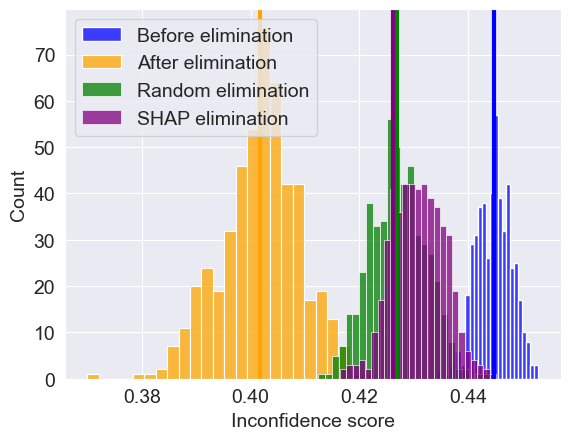

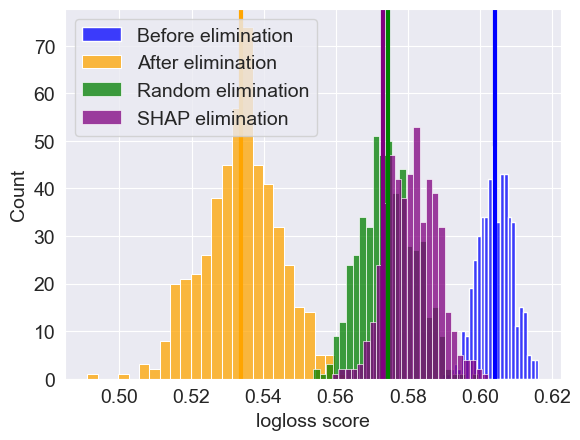

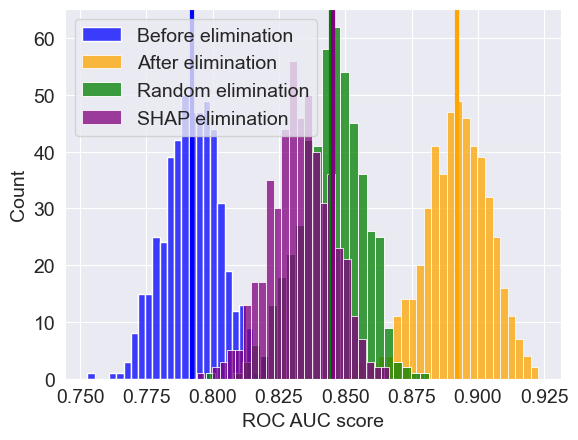

In [39]:
for k, label in enumerate(['Inconfidence score', 'logloss score', 'ROC AUC score']):
    plt.figure()
    plot_scores(metrics_before[k], metrics_after[k], metrics_r[k], metrics_s[k], label)

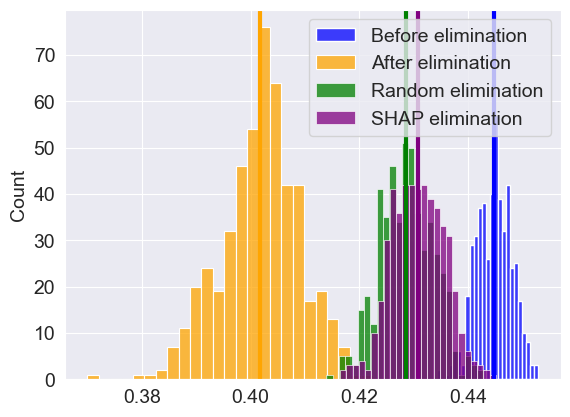

In [55]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[0], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[0]), color="purple", linewidth=3)
plt.legend()

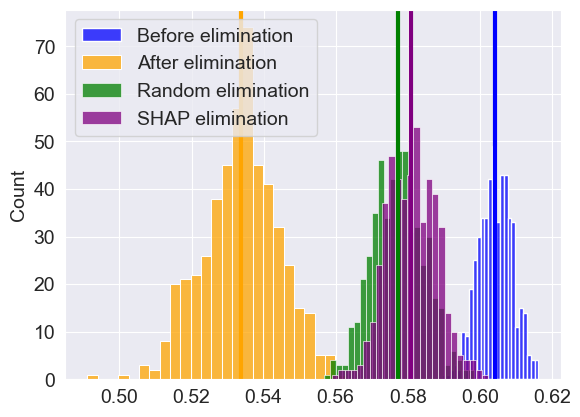

In [56]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[1], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[1]), color="purple", linewidth=3)
plt.legend()

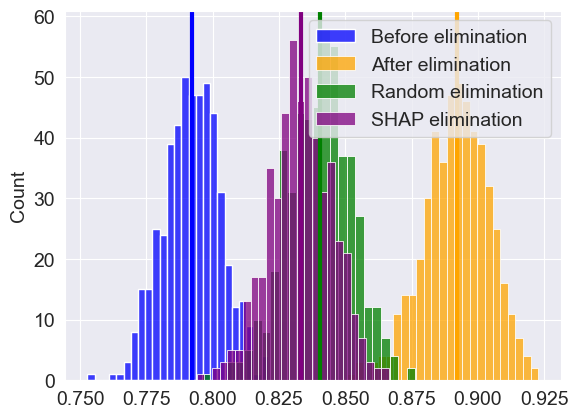

In [57]:
sns.histplot(metrics_before[2], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[2], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[2], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[2], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[2]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[2]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[2]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[2]), color="purple", linewidth=3)
plt.legend()

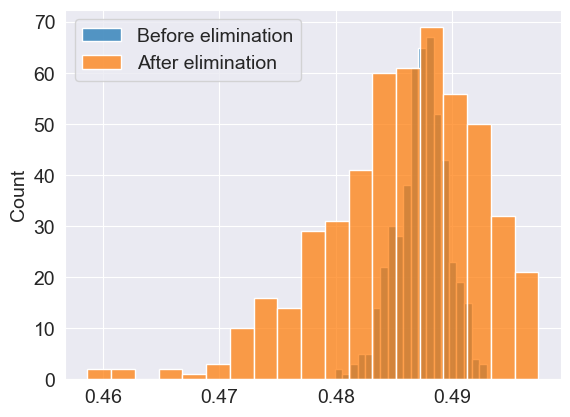

In [261]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [229]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=45.363657433495675, pvalue=3.570673536410195e-179, df=499)

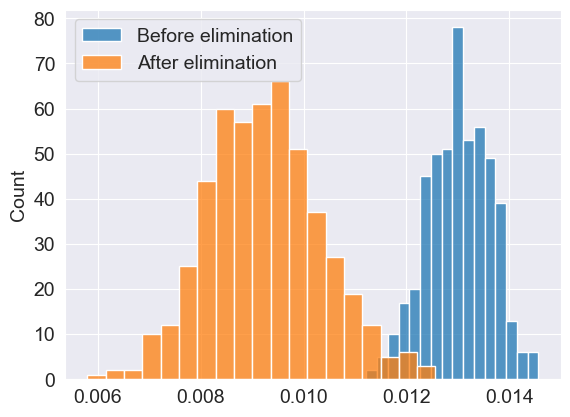

In [81]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [37]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=3.5513027688261474, pvalue=0.0005886470203057337)

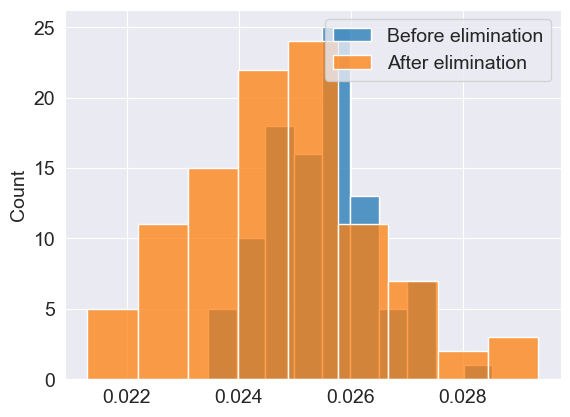

In [39]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [40]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=4.5674716964522615, pvalue=1.4238634976675129e-05)

In [41]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [42]:
disc_data_onehot

,Tsurf_mean_0,Tsurf_mean_1,Tsurf_mean_2,Water_mean_0,Water_mean_1,Water_mean_2,Speed_mean_0,Speed_mean_1,Speed_mean_2,totalSnow_cm_0,...,humidity_2,precipMM_0,precipMM_1,precipMM_2,pressure_0,pressure_1,pressure_2,sq_error_0,sq_error_1,sq_error_2
0,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0
3,0,0,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
996,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
997,0,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
998,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [43]:
gbn = DiscreteBNGI(imagespath)

In [44]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

KeyError: 'Tsurf_mean_0'

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")